# Embedding and Bias Analysis - a linear algebra approach

related to https://stdm.github.io/downloads/papers/ANNPR_2020.pdf


### Projection 

The centers of the 4 racial clusters span a (4-1)d=3d subspace of the embedding space. This 3d space is visualized below (section 1). Remarks:
- This simple construction yields nice clusters
- The structure of the clusters can be easily explored as it is in 3d
- By construction, it is a proper subspace of a the embedding vector space. 
- Therefore, the empedding space is partitioned in a 3d "racial" space and a (n-3)d "racially blinded" space (see PCA in section 5)
- Also, each substance has a well defined variance and contributes accordingly to the total variance (see section 2). There variance of the race contributes 7-15% to the total variance depending on the model.

### Clustering scores

Section 3 gives the clustering scores. They indicate marginal clustering for the full embedding space, decent clustering for the 3d subspace and no clustering for the remaining subspace. As a consequence, the clustering scores reflect clustering in 3 dimensions and are not a measure for the whole embedding space. Since face recognition includes the whole embedding space, clustering scores cannot expected to be representative (as the paper shows...).

The distance analysis in section 4 shows that "nearest neighebor distances between clusters < pairwise distances within a single cluster". This reflects the fact, that the clustering is marginal in the total embedding space.


### What can we do then about the bias?

Still, wie have the problem, that the recognition rate depend on race. I assume the main reason is that discriminating face characteristics within a given race were not equally well trained for different races. Or simpler: The training set for Caucasians was much bigger. The algorithm is better trained to dicriminate face characteristics of Caucasians. 

So, how to proceed?
- Difference in recognition rate should be measured directly with personal labels. Done in https://arxiv.org/abs/2009.07838. Idea from this paper: Include false positive rate
- Looking where false positive/negative are located in the 3d race space may give a hint where to do further training 


### Further ideas

- This projection approach opens a new route to shed light into the embedding space. The different dimensions become meaning. The contribution of different face characteristics to the embedding space can be quantified.
- Explore the face recognition rate of the "racially blinded" subspace.
- ...


### Literatur, Links
- https://towardsdatascience.com/introduction-to-best-parallel-plot-python-library-hiplot-8387f5786d97
- https://machinelearningmastery.com/how-to-perform-face-recognition-with-vggface2-convolutional-neural-network-in-keras/



### Import and Helpers

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.linalg import orth
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from sklearn.neighbors import DistanceMetric
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score

mystore = r'C:\Daten\_tmp\FRdata.h5'

In [2]:
class H5Reader:
    pattern = r'C:\Daten\FaceRecognitionBias\vgg2\embeddings\{net}_pytorch_{race}_normed_BGR.h5'
    race_list = ['Caucasian','Indian','Asian','African']
    net_list = ['senet50_128','senet50_256','senet50_ft']
    
    
    def __init__(self, net):
        self.net = net
        
    @classmethod
    def net(cls, ind):
        return cls.net_list[ind]
        
    @classmethod
    def race(cls, ind):
        if type(ind) == str:
            return list(filter(lambda s: s.lower().startswith(ind.lower()),cls.race_list))[0]
        else:
            return cls.race_list[ind]
        
    def path(self, race):
        race = list(filter(lambda s: s.lower().startswith(race.lower()),self.race_list))[0]
        return self.pattern.format(net = self.net, race = race)
        
    def read(self, race_prefix, race_index = False, key = '/embeddings'):
        race = self.race(race_prefix)
        path = self.pattern.format(net = self.net, race = race)
        df = pd.read_hdf(path, key)
        if race_index:
            df['race_index'] = self.race_list.index(race)
        return df
    
    def read_all(self, N=None, select = 'head', key = '/embeddings'):
        out = []
        for race in self.race_list:
            df = self.read(race, race_index=True, key = key)
            if N is None:
                out.append(df)
            elif select == 'head':
                out.append(df.head(N))
            else:
                out.append(df.tail(N))    
                
        return pd.concat(out,0).set_index('race_index').reset_index()
    
    def read_pair_labels(self, N=None, select = 'head'):
        df = self.read_all(key='/images',N=N, select=select)
        return (df['class'] + '_' + df.img.apply(lambda s: s[:-4].split('.')[1])).values
        
                
    def keys(self, race_prefix):    
        race = self.race(race_prefix)
        path = self.pattern.format(net = self.net, race = race)
        with pd.HDFStore(path) as hdf:
            out = hdf.keys()
        return out
    
    @staticmethod
    def df2data(df):
        return df.filter(regex='\d').values, df.filter(regex='\D').values.flatten()
    
    @staticmethod
    def replacedata(df,X):
        return pd.concat([df.filter(regex='\D'), pd.DataFrame(X)],1)
    
    
r128 = H5Reader('senet50_128')
r128.read_pair_labels()

array(['Caucasian_0cl29w_0001', 'Caucasian_0cl29w_0003',
       'Caucasian_0cl29w_0002', ..., 'African_05c1c5_0003',
       'African_05c1c5_0002', 'African_05c1c5_0001'], dtype=object)

In [3]:
# a class to project on subspaces
class ClusterCenterProjection:
    
    def fit(self,X, labels):
        centers = np.array([np.mean(X[labels==label,:],0) for label in np.unique(labels)])
        vectors = centers[1:,:] - centers[:1,:]
        self._basis = (vectors[0,:]/np.linalg.norm(vectors[0,:])).reshape([1,-1])
        # gram schmidt orthogonalization
        for iv in range(1,vectors.shape[0]):
            new_basis_vector = self.blind(vectors[iv,:])
            new_basis_vector = (new_basis_vector / np.linalg.norm(new_basis_vector)).reshape([1,-1])
            self._basis = np.concatenate([self._basis, new_basis_vector])
              

    def fit2(self,X, labels):
        centers = np.array([np.mean(X[labels==label,:],0) for label in np.unique(labels)])
        self._basis = orth((centers[1:,:] - centers[:1,:]).T).T
        
    def project(self,X, keepdims = False):
        out = np.dot(X,self._basis.T)
        if keepdims:
            out = np.dot(out, self._basis)
        return out
    
    def blind(self, X):
        return X - self.project(X,keepdims=True)
        
ccp = ClusterCenterProjection()
df = H5Reader('senet50_128').read_all()
X,y = H5Reader.df2data(df)
ccp.fit(X,y)
df = H5Reader.replacedata(df,ccp.blind(X))

### Class for face recognition distances between defined  (RFW) pairs 

- you need the labels m.0bmgl10_0001 -> The devine the images uniquely
- the metric works in the space of pairs: pair_dist = fun(pair, embeddings+label). pair_label = fun(pair_distance)
- The threshold in the paper is on cosine distances  (but could be euclidean as well)
- Note: Some people Ids (example '01pw5d') occur in several races (african & indian for the example). However, pairs are defined strictly within race. Therefore I don't know whether these are the same person... 


https://openaccess.thecvf.com/content_ICCV_2019/papers/Wang_Racial_Faces_in_the_Wild_Reducing_Racial_Bias_by_Information_ICCV_2019_paper.pdf

In [5]:
class RFWDistances:
    pattern = r'C:\Daten\FaceRecognitionBias\RFW\{race}\{race}_pairs.txt'
    race_list = ['Caucasian','Indian','Asian','African']
    
    @staticmethod
    def _label1(s):
        s = s.split('\t')
        return s[0].split('.')[1] + '_' + s[1].zfill(4)

    @staticmethod
    def _label2(s):
        s = s.split('\t')
        if len(s) == 3:
            return s[0].split('.')[1] + '_' + s[2].zfill(4)
        else:
            return s[2].split('.')[1] + '_' + s[3].zfill(4)
        
    @staticmethod
    def _issame(s):
        return np.int8(len(s.split('\t'))==3)
        
    def __init__(self):
        df = [pd.read_csv(self.pattern.format(race=race),header=None).assign(race=race) for race in self.race_list]
        df = pd.concat(df,0).reset_index(drop=True)
        df['label1'] = df.race + '_' + df[0].apply(self._label1)
        df['label2'] = df.race + '_' + df[0].apply(self._label2)
        df['issame'] = df[0].apply(self._issame)
        self._df = df.drop(columns=[0])
        
    def _get_metric_empeddings(self, embeddings, labels):
        edf = pd.DataFrame(embeddings)
        edf.index = labels
        X1 = edf.reindex(self._df.label1).values
        X2 = edf.reindex(self._df.label2).values
        return X1, X2

    def get_distance_df(self, embeddings, labels):
        X1, X2 = self._get_metric_empeddings(embeddings, labels)
        df = self._df.copy()
        df['cos'] = np.array([cosine(X1[ii], X2[ii]) for ii in range(X1.shape[0])])
        df['eucl'] = np.linalg.norm(X1-X2,axis=1)
        return df
    
    def get_prod_df(self, embeddings, labels):
        X1, X2 = self._get_metric_empeddings(embeddings, labels)
        X1 = X1 / np.linalg.norm(X1, axis=1, keepdims=True)
        X2 = X2 / np.linalg.norm(X2, axis=1, keepdims=True)
        return pd.concat([self._df.copy(), pd.DataFrame(X1*X2)],1)
    
r128 = H5Reader('senet50_128')
labels = r128.read_pair_labels()
embeddings = r128.read_all().filter(regex=r'\d')
frm = RFWDistances()
#df = frm.get_distance_df(embeddings,labels).dropna()
df = frm.get_prod_df(embeddings,labels).dropna()
df.head()

,race,label1,label2,issame,0,1,2,3,4,5,...,118,119,120,121,122,123,124,125,126,127
0,Caucasian,Caucasian_027n6t8_0003,Caucasian_027n6t8_0002,1,0.000347,0.007766,-0.003669,-0.000440,0.006183,0.000601,...,0.003672,0.000323,-0.011650,0.006059,0.027800,0.009012,0.011446,0.009883,-0.000855,-0.003845
1,Caucasian,Caucasian_016lb3_0004,Caucasian_016lb3_0002,1,0.005284,0.000439,0.092991,-0.000315,0.000054,0.008841,...,0.000949,-0.002264,0.010606,-0.000345,-0.000244,0.000649,0.009612,0.003735,0.000688,-0.005686
2,Caucasian,Caucasian_02_4qt_0003,Caucasian_02_4qt_0002,1,0.018574,-0.000820,0.007591,0.001681,0.000019,0.000281,...,-0.000047,0.002643,0.001764,0.026033,0.003674,-0.001742,0.015746,-0.002108,0.000943,-0.000438
3,Caucasian,Caucasian_09g8fj_0003,Caucasian_09g8fj_0001,1,-0.000012,0.000011,-0.004428,0.022004,0.018864,0.008636,...,0.010079,0.017713,0.001475,0.008130,0.001738,-0.000049,0.017045,0.021450,-0.000695,0.009277
4,Caucasian,Caucasian_01q3xr_0001,Caucasian_01q3xr_0003,1,0.006906,0.003197,0.005273,0.035967,0.019806,-0.000618,...,0.009204,0.013483,0.002462,0.004893,0.011105,0.006397,-0.001755,0.015074,0.000028,0.002898


# 1. Subspace projection (3D) 

In a first step I project the empeddings into a 3D-space spannend by the centers (averages) of the clusters. As a result I get beautifully structured clusters.

### senet50_128

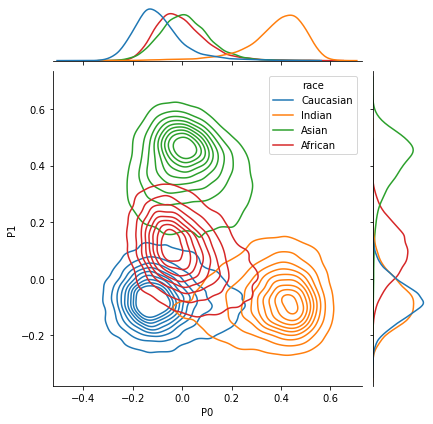

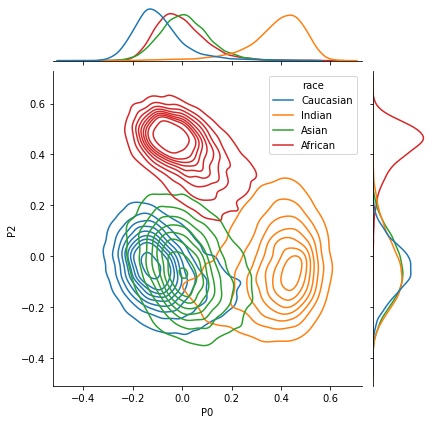

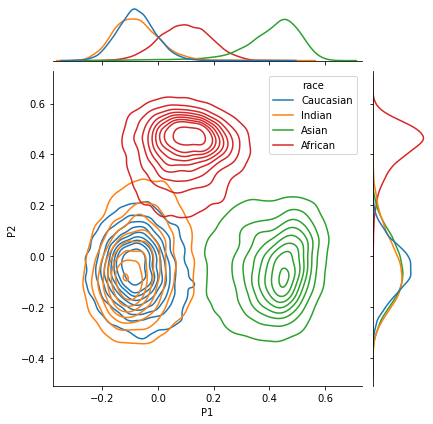

In [7]:
rd = H5Reader('senet50_128')
df = rd.read_all(9500)
ccp = ClusterCenterProjection()
X, labels = H5Reader.df2data(df)
ccp.fit(X,labels)
P3d_df = H5Reader.replacedata(df,ccp.project(X)).rename(columns={0:'P0',1:'P1',2:'P2'})
P3d_df['race'] = P3d_df.race_index.apply(H5Reader.race)

sns.jointplot(x='P0', y='P1',hue='race',data=P3d_df,kind="kde")
plt.show()
sns.jointplot(x='P0', y='P2',hue='race',data=P3d_df,kind="kde")
plt.show()
sns.jointplot(x='P1', y='P2',hue='race',data=P3d_df,kind="kde")
plt.show()

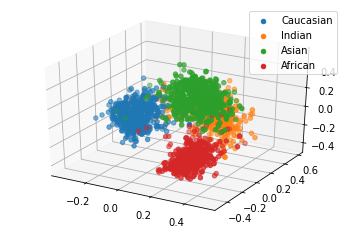

In [5]:
# %matplotlib notebook
N = 500
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for ir in P3d_df.race_index.unique():
    sel = P3d_df.race_index == ir
    ax.scatter(P3d_df[sel]['P0'][:N], P3d_df[sel]['P1'][:N], P3d_df[sel]['P2'][:N],label=H5Reader.race(ir))
ax.legend()

### senet50_256

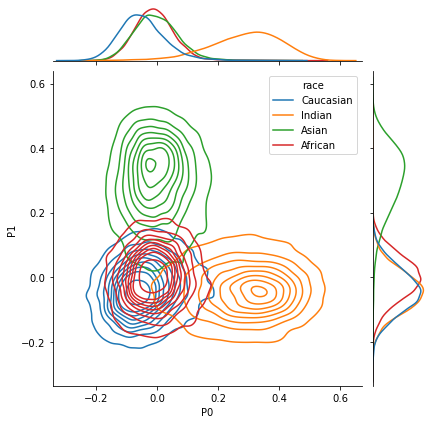

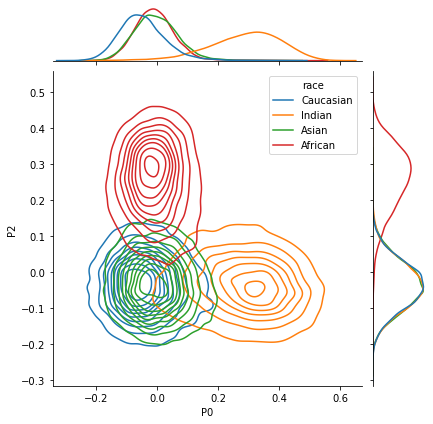

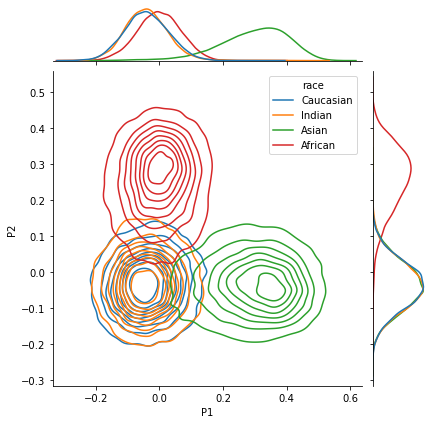

In [8]:
rd = H5Reader('senet50_256')
df = rd.read_all(9500)
ccp = ClusterCenterProjection()
X, labels = H5Reader.df2data(df)
ccp.fit(X,labels)
P3d_df = H5Reader.replacedata(df,ccp.project(X)).rename(columns={0:'P0',1:'P1',2:'P2'})
P3d_df['race'] = P3d_df.race_index.apply(H5Reader.race)

sns.jointplot(x='P0', y='P1',hue='race',data=P3d_df,kind="kde")
plt.show()
sns.jointplot(x='P0', y='P2',hue='race',data=P3d_df,kind="kde")
plt.show()
sns.jointplot(x='P1', y='P2',hue='race',data=P3d_df,kind="kde")
plt.show()

### senet50_ft

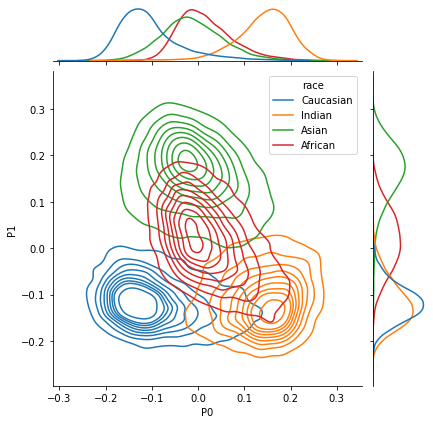

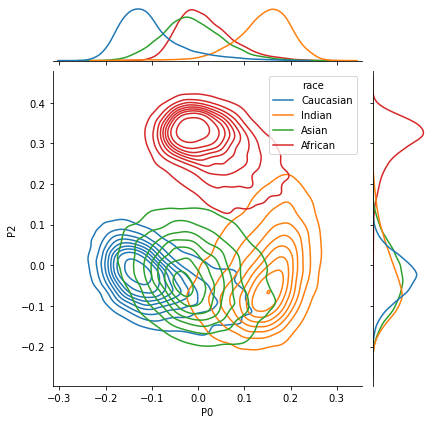

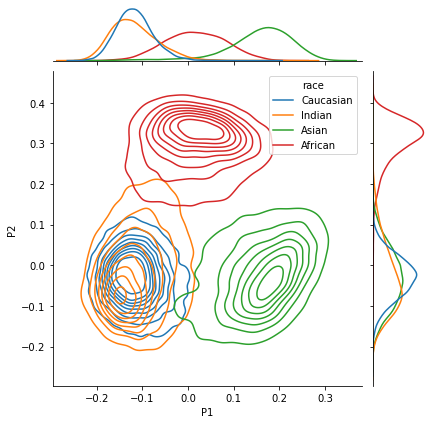

In [9]:
rd = H5Reader('senet50_ft')
df = rd.read_all(9500)
ccp = ClusterCenterProjection()
X, labels = H5Reader.df2data(df)
ccp.fit(X,labels)
P3d_df = H5Reader.replacedata(df,ccp.project(X)).rename(columns={0:'P0',1:'P1',2:'P2'})
P3d_df['race'] = P3d_df.race_index.apply(H5Reader.race)

sns.jointplot(x='P0', y='P1',hue='race',data=P3d_df,kind="kde")
plt.show()
sns.jointplot(x='P0', y='P2',hue='race',data=P3d_df,kind="kde")
plt.show()
sns.jointplot(x='P1', y='P2',hue='race',data=P3d_df,kind="kde")
plt.show()

# 2. Variance

In [22]:
vardf = []
ccp = ClusterCenterProjection()
for net in H5Reader.net_list:
    df = H5Reader(net).read_all()
    df['race'] = df.race_index.apply(H5Reader.race)
    df.drop(columns=['race_index'],inplace = True)
    X, labels = H5Reader.df2data(df)
    ccp.fit(X,labels)
    for ix,X2 in enumerate([X, ccp.project(X), ccp.blind(X)]):
        newdf = H5Reader.replacedata(df,X2).groupby('race').var().T.sum()
        newdf = pd.DataFrame(newdf,columns=['variance'])
        newdf.loc['Total',['variance']] = np.sum(np.var(X2,0))
        newdf['Net'] = net
        newdf['Type'] = {0:'full',1:'3d',2:'blinded'}[ix]
        vardf.append(newdf)

vardf = (pd.concat(vardf,0)
 .reset_index()
 .set_index(['race','Net','Type'])
 .unstack(['Net','Type'])
 .reindex(H5Reader.race_list + ['Total'])
)  

vardf

variance                                                      \
Net       senet50_128                     senet50_256                       
Type             full        3d   blinded        full        3d   blinded   
race                                                                        
Caucasian    0.962882  0.025255  0.937627    0.987675  0.014945  0.972730   
Indian       0.826110  0.038815  0.787294    0.906292  0.023025  0.883267   
Asian        0.814082  0.037556  0.776526    0.904100  0.021526  0.882575   
African      0.789606  0.028488  0.761118    0.927298  0.017653  0.909644   
Total        0.962477  0.146923  0.815550    0.985039  0.072817  0.912218   

                                          
Net       senet50_ft                      
Type            full        3d   blinded  
race                                      
Caucasian   0.394439  0.008927  0.385512  
Indian      0.385527  0.013788  0.371738  
Asian       0.394231  0.014903  0.379328  
African     0.328315  0.011973  0.316342  
Total       0.416367  0.053692  0.362674

### Percentage value relative to total variance

In [25]:
(100*vardf / vardf.values[4,[0,0,0,3,3,3,6,6,6]]).astype(float).round(1)

variance                                                          \
Net       senet50_128               senet50_256              senet50_ft         
Type             full    3d blinded        full   3d blinded       full    3d   
race                                                                            
Caucasian       100.0   2.6    97.4       100.3  1.5    98.8       94.7   2.1   
Indian           85.8   4.0    81.8        92.0  2.3    89.7       92.6   3.3   
Asian            84.6   3.9    80.7        91.8  2.2    89.6       94.7   3.6   
African          82.0   3.0    79.1        94.1  1.8    92.3       78.9   2.9   
Total           100.0  15.3    84.7       100.0  7.4    92.6      100.0  12.9   

                   
Net                
Type      blinded  
race               
Caucasian    92.6  
Indian       89.3  
Asian        91.1  
African      76.0  
Total        87.1

# 3. Interpretaion of the cluster scores 

I wonder what cluster with the same scores look like in 2d. Therefore i create two clusters out of uniform random point seperated by a distance of 1 (see figure). In order to get similar scores as in the paper, the clusters have to be very badly structured... [Wikipedia](https://de.wikipedia.org/wiki/Silhouettenkoeffizient) confirms this for the values of the Silhouette score: 

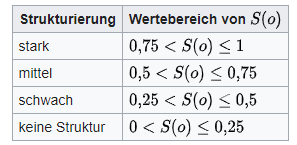

In [23]:
# functions for score calculations
def calculate_scores(X, labels):
    clf = LogisticRegression(random_state=0,max_iter=200).fit(X, labels)
    return {'MS': silhouette_score(X, labels),
            'CH': calinski_harabasz_score(X, labels),
            'DB': davies_bouldin_score(X, labels),
            'Log. regr.':clf.score(X,labels)}

def uniform_2d_clusters(w,N=1000):
    labels = np.int8(np.arange(2*N)/N)
    X = np.concatenate([labels.reshape([-1,1]),w*np.random.uniform(size=[2*N,1])],1)
    return X, labels

### Full empedding space

In [24]:
# reproduce scores of the paper
score_df = []
for net in H5Reader.net_list:
    df = H5Reader(net).read_all()
    X, labels = H5Reader.df2data(df)    
    out = calculate_scores(X, labels)
    score_df.append(pd.DataFrame(pd.Series(out),columns=[net]))
score_df_full = pd.concat(score_df,1).T
score_df_full

,MS,CH,DB,Log. regr.
senet50_128,0.062520,1814.013511,3.849993,0.964954
senet50_256,0.029696,772.702830,6.180902,0.961408
senet50_ft,0.050755,1480.753377,4.449591,0.965128


### 3d "racial" space

In [26]:
# scores of cluster projected onto 3d space (see below)
score_df = []
for net in H5Reader.net_list:
    df = H5Reader(net).read_all()
    X, labels = H5Reader.df2data(df)
    ccp = ClusterCenterProjection()
    ccp.fit(X,labels)
    out = calculate_scores(ccp.project(X,keepdims=True), labels)
    score_df.append(pd.DataFrame(pd.Series(out),columns=[net]))
score_df_3d = pd.concat(score_df,1).T
score_df_3d

,MS,CH,DB,Log. regr.
senet50_128,0.532320,47401.307836,0.633584,0.957861
senet50_256,0.445669,37376.487282,0.753675,0.934721
senet50_ft,0.504623,44906.178332,0.696603,0.949900


### "racially blinded" space

In [25]:
# scores of cluster projected onto 3d space (see below)
score_df = []
for net in H5Reader.net_list:
    df = H5Reader(net).read_all()
    X, labels = H5Reader.df2data(df)
    ccp = ClusterCenterProjection()
    ccp.fit(X,labels)
    out = calculate_scores(ccp.blind(X), labels)
    score_df.append(pd.DataFrame(pd.Series(out),columns=[net]))
score_df_blind = pd.concat(score_df,1).T
score_df_blind

,MS,CH,DB,Log. regr.
senet50_128,-0.013535,6.382484e-09,2.696903e+06,0.257868
senet50_256,-0.007251,2.685620e-09,4.221559e+06,0.257868
senet50_ft,-0.020183,2.725593e-07,5.452288e+05,0.257868


### summary table

In [41]:
cols = ['Log. regr.','MS', 'CH', 'DB']
(pd.concat([score_df_full[cols].assign(type='aware'),score_df_blind[cols].assign(type='blind')],0)
 .reset_index()
 .rename(columns={'index':'model'})
 .sort_values(by='model')
 .set_index(['model','type'])
 .T.round(3) )

model      senet50_128              senet50_256              senet50_ft  \
type             aware        blind       aware        blind      aware   
Log. regr.       0.965        0.258       0.961        0.258      0.965   
MS               0.063       -0.014       0.030       -0.007      0.051   
CH            1814.014        0.000     772.703        0.000   1480.753   
DB               3.850  2696903.014       6.181  4221558.532      4.450   

model                   
type             blind  
Log. regr.       0.258  
MS              -0.020  
CH               0.000  
DB          545228.772

### Similar score in 3d

In [66]:
# scores of 2d cluster as described above
score_df = []
for w in [5,10,20,50,100]:
    X, labels = uniform_2d_clusters(w)    
    out = calculate_scores(X, labels)
    score_df.append(pd.DataFrame(pd.Series(out),columns=[w]))
score_df = pd.concat(score_df,1).T
score_df

,MS,CH,DB
5,0.196238,242.653163,2.488223
10,0.075356,61.106214,4.968992
20,0.024846,15.795604,9.749855
50,0.005463,2.810364,23.091799
100,0.003842,6.139537,15.599439


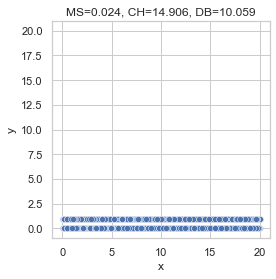

In [257]:
N = 20
X, labels = uniform_2d_clusters(20)
df = pd.DataFrame(labels, columns=['label'])
df['x'] = X[:,1]
df['y'] = X[:,0]
scores = calculate_scores(X,labels)
g = sns.scatterplot(x='x',y='y',data=df)
g.set(xlim=[-1,N+1],ylim=[-1,N+1],aspect = 1)
plt.title(', '.join([key+'='+str(np.round(val,3)) for key,val in scores.items()]))
plt.show()

# 4. Distance Analysis

### Next Steps
- [x] Alles mit Euklidischer Distanz rechnen
- [x] Nur die nächsten Nachbarn anschauen
- [x] Make nearest neighbor plot over all three nets
- [ ] Further investigate confusion matrices

## 4.1 Preprocessing 
 
Time consuming calculations. Results stored to hdf

In [32]:
# calculate euclidean distances between clusters
N = 300
df = []
dist = DistanceMetric.get_metric('euclidean')
for inet, net in enumerate(H5Reader.net_list):
    rd = H5Reader(net)
    for irace, race1 in enumerate(H5Reader.race_list):
        for jrace,race2 in enumerate(H5Reader.race_list):
            X1 = rd.read(race1).head(N).values
            X2 = rd.read(race2).tail(N).values
            distances =dist.pairwise(X1,X2).flatten().astype(np.float32)
            new_df = pd.DataFrame(distances,columns = ['distance'])
            new_df['net_index'] = np.int8(inet)
            new_df['race_index1'] = np.int8(irace)
            new_df['race_index2'] = np.int8(jrace)
            df.append(new_df)
            
# save to store
df = pd.concat(df,0)
df.to_hdf(mystore,'cluster_eucl_distances')

In [33]:
# calculate euclidean distances between clusters for 3d projection
N = 300
df = []
dist = DistanceMetric.get_metric('euclidean')
for inet, net in enumerate(H5Reader.net_list):
    rd = H5Reader(net)
    raw_df = projection3d(rd.read_all())
    for irace, race1 in enumerate(H5Reader.race_list):
        for jrace,race2 in enumerate(H5Reader.race_list):
            X1 = raw_df.query('race_index==@irace').filter(regex=r'\d').head(N).values
            X2 = raw_df.query('race_index==@jrace').filter(regex=r'\d').tail(N).values
            distances =dist.pairwise(X1,X2).flatten().astype(np.float32)
            new_df = pd.DataFrame(distances,columns = ['distance'])
            new_df['net_index'] = np.int8(inet)
            new_df['race_index1'] = np.int8(irace)
            new_df['race_index2'] = np.int8(jrace)
            df.append(new_df)
            
# save to store
df = pd.concat(df,0)
df.to_hdf(mystore,'cluster_eucl_distances_3d')

In [25]:
# !!!!!!!!!! TAKES HOURS TO RUN !!!!!!!!!!!!!!!!!
# calculate nearest neighbor euclidean distances between clusters
N = 9500 # much higher for nearest neighbor distances
df = []
for inet, net in enumerate(H5Reader.net_list):
    rd = H5Reader(net)
    for irace, race1 in enumerate(H5Reader.race_list):
        for jrace,race2 in enumerate(H5Reader.race_list):
            X1 = rd.read(race1).head(N).values
            X2 = rd.read(race2).head(N).values
            n_neighbors = 2 if race1 == race2 else 1            
            neigh = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree')
            neigh.fit(X1)
            distances, indices = neigh.kneighbors(X2)
            new_df = pd.DataFrame(distances[:,-1], columns=['distance'])
            new_df['nn_index'] = indices[:,-1]
            new_df['net_index'] = np.int8(inet)
            new_df['race_index1'] = np.int8(irace)
            new_df['race_index2'] = np.int8(jrace)
            df.append(new_df)

# save to store
df = pd.concat(df,0)
df.to_hdf(mystore,'nn_eucl_distances')

In [21]:
df = pd.read_hdf(mystore,'nn_eucl_distances')
df.query('net_index==0').head(15)

,distance,nn_index,net_index,race_index1,race_index2
0,0.934786,8517,0,0,0
1,0.948649,6090,0,0,0
2,0.813971,1716,0,0,0
3,0.596464,5,0,0,0
4,0.686765,3,0,0,0
5,0.596464,3,0,0,0
6,0.680216,5,0,0,0
7,0.469712,8,0,0,0
8,0.469712,7,0,0,0
9,0.628257,7,0,0,0


In [22]:
r128 = H5Reader('senet50_128')
r128.read_all(N=9500,key='/images').head(15)

,race_index,class,subject,img
0,0,Caucasian,m.0cl29w,m.0cl29w_0001.jpg
1,0,Caucasian,m.0cl29w,m.0cl29w_0003.jpg
2,0,Caucasian,m.0cl29w,m.0cl29w_0002.jpg
3,0,Caucasian,m.02qtdjx,m.02qtdjx_0004.jpg
4,0,Caucasian,m.02qtdjx,m.02qtdjx_0003.jpg
5,0,Caucasian,m.02qtdjx,m.02qtdjx_0002.jpg
6,0,Caucasian,m.02qtdjx,m.02qtdjx_0001.jpg
7,0,Caucasian,m.072d5h,m.072d5h_0002.jpg
8,0,Caucasian,m.072d5h,m.072d5h_0003.jpg
9,0,Caucasian,m.072d5h,m.072d5h_0001.jpg


## 4.2 Distance distributions 

Plots in this section show
- Violin plots of (euclidean) distance distribution
- The distances are between points of same clusters (diagonal case) or between points of different clusters (off-diagonal cas)
- The distributions represent either all pairwise distances (pair case) or distances to neares neighbors (nn case)

C:\Users\wehs\.conda\envs\ds\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\wehs\.conda\envs\ds\lib\site-packages\seaborn\axisgrid.py:650: UserWarning: Using the violinplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


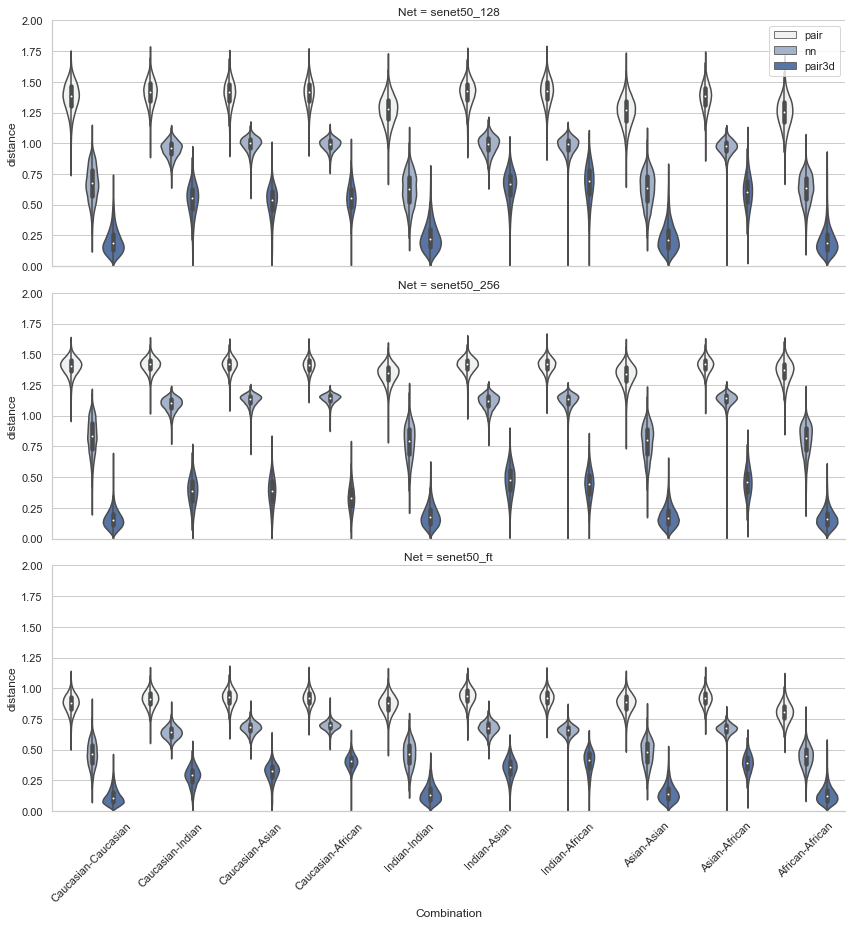

In [38]:
%matplotlib inline
df = pd.concat(
    [pd.read_hdf(mystore,'cluster_eucl_distances').assign(type1='pair'),
     pd.read_hdf(mystore,'nn_eucl_distances').assign(type1='nn'),
     pd.read_hdf(mystore,'cluster_eucl_distances_3d').assign(type1='pair3d')
     ],0).query('race_index2 >= race_index1')
df['Combination'] = df.race_index1.apply(H5Reader.race) + '-' + df.race_index2.apply(H5Reader.race)
df['Net'] = df.net_index.apply(H5Reader.net)

sns.set_theme(style="whitegrid")
g = sns.FacetGrid(df,row='Net',aspect=3,height=4, legend_out=True)
g.map(sns.violinplot, 'Combination','distance','type1')
g.set(ylim=(0, 2))
g.set_xticklabels(rotation=45)
g.fig.get_axes()[0].legend()

### Condensed distributions

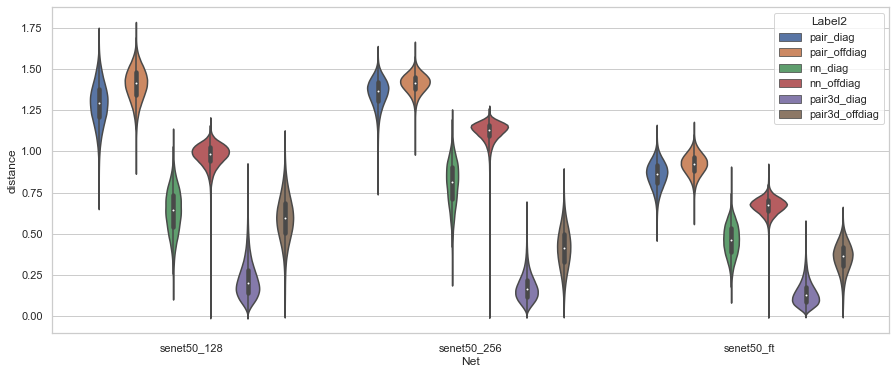

In [39]:
df['type2'] = (df.race_index1 == df.race_index2).apply(lambda b: 'diag' if b else 'offdiag')
df['Label2'] = df.type1 + '_' + df.type2
plt.figure(figsize=(15,6))
sns.violinplot(x='Net',y='distance',hue='Label2',data=df)

### Fraction of points which are nearest neighbors

In off-diagonal distances, still 30% of points are nearest neighbors!

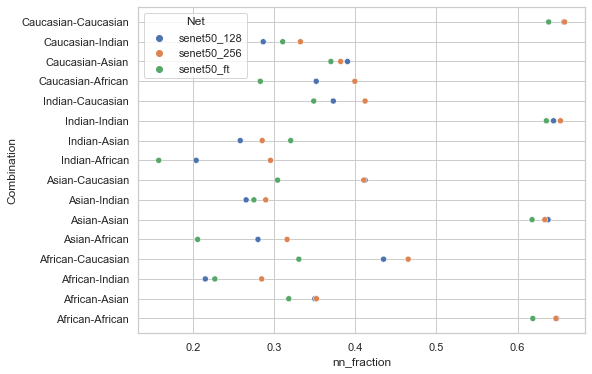

In [186]:
tmp = (df.query("type1=='nn'")
     .groupby(['net_index','race_index1','race_index2'])
     .apply(lambda df: pd.Series({'nn_fraction':len(df.nn_index.unique())/9500,
                                  'Combination':df.Combination[0],
                                 'Net':df.Net[0]})))
tmp = pd.DataFrame(tmp).reset_index()
plt.figure(figsize=(8,6))
g = sns.scatterplot(y='Combination',x='nn_fraction',hue='Net',data=tmp)

# 5 PCA

### Full data

In [111]:
N = 9500
n_components = 8
pcadf = []
pca = PCA(n_components=n_components)
for net in H5Reader.net_list:
    df = H5Reader(net).read_all(N)
    X,_ = H5Reader.df2data(df)
    df = H5Reader.replacedata(df,pca.fit_transform(X))
    df['Net']=net
    pcadf.append(df.set_index(['race_index','Net']).stack().reset_index())

pcadf = pd.concat(pcadf,0).rename(columns={'level_2':'pca_index',0:'value'})
pcadf['race'] = pcadf.race_index.apply(H5Reader.race)

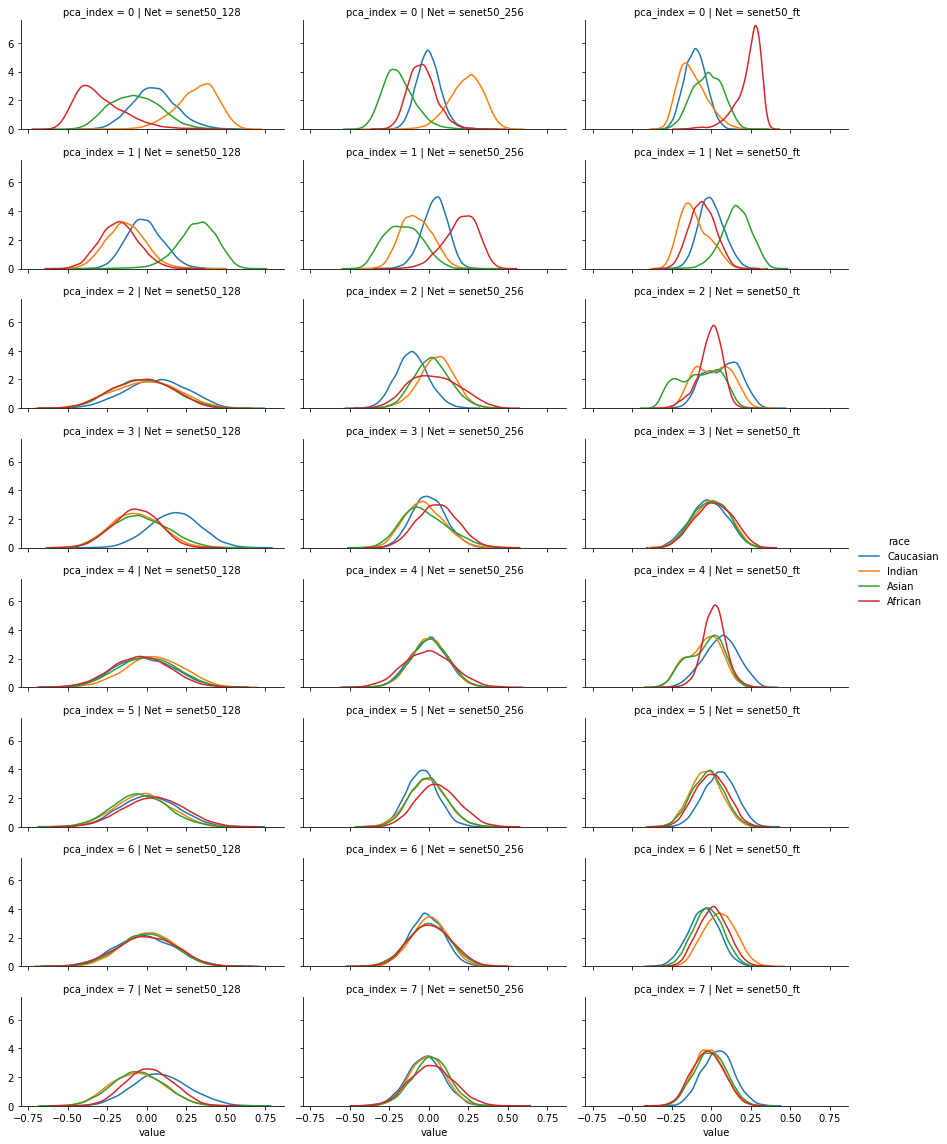

In [112]:
g = sns.FacetGrid(pcadf,col='Net',row='pca_index',hue='race',aspect=2,height=2, legend_out=True)
g.map(sns.kdeplot, 'value')
g.add_legend()

### racially blinded data

In [113]:
N = 9500
n_components = 8
pcadf = []
pca = PCA(n_components=n_components)
for net in H5Reader.net_list:
    df = H5Reader(net).read_all(N)
    X,y = H5Reader.df2data(df)
    ccp = ClusterCenterProjection()
    ccp.fit(X,y)
    df = H5Reader.replacedata(df,pca.fit_transform(ccp.blind(X)))
    df['Net']=net
    pcadf.append(df.set_index(['race_index','Net']).stack().reset_index())

pcadf = pd.concat(pcadf,0).rename(columns={'level_2':'pca_index',0:'value'})
pcadf['race'] = pcadf.race_index.apply(H5Reader.race)

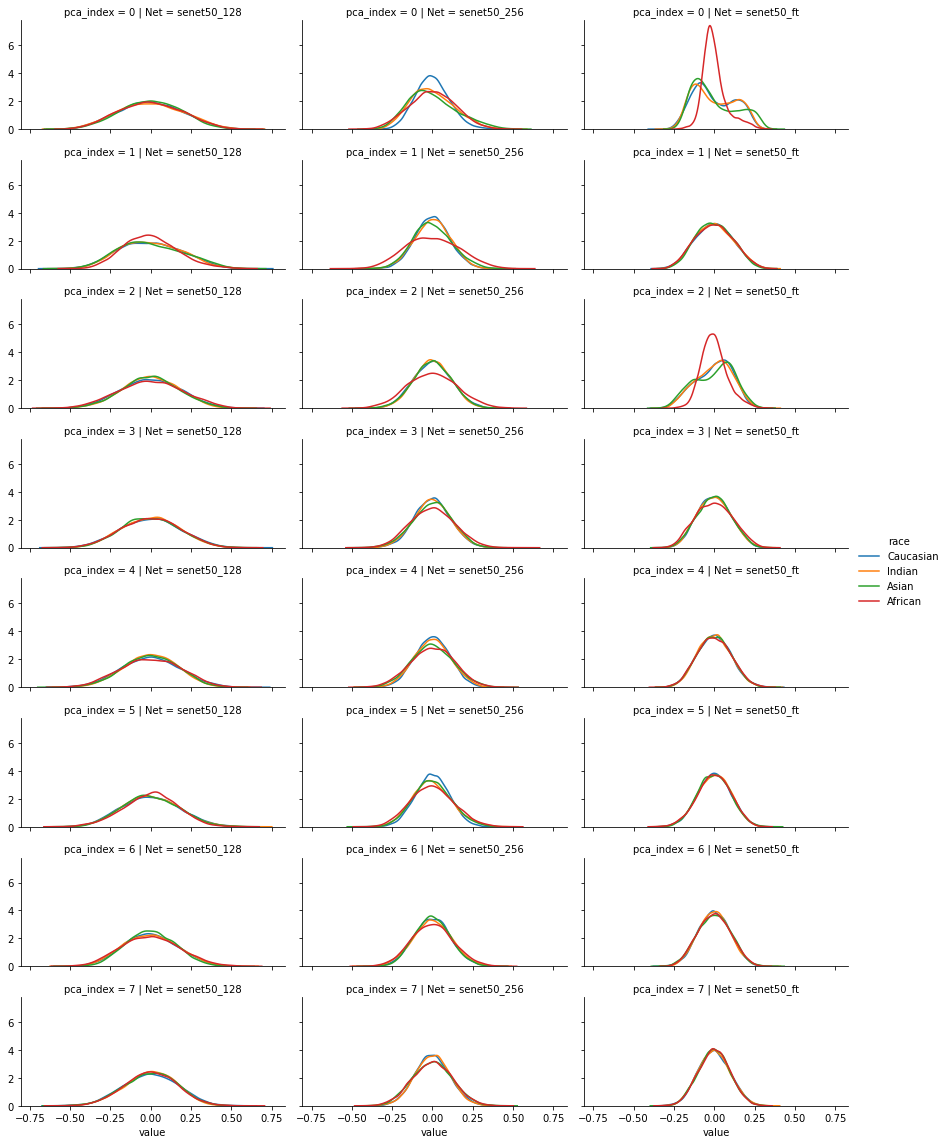

In [114]:
g = sns.FacetGrid(pcadf,col='Net',row='pca_index',hue='race',aspect=2,height=2, legend_out=True)
g.map(sns.kdeplot, 'value')
g.add_legend()

# 6. RFW Pair metric for face recogition

### Insights

- The good classification threshold depends on the race. Caucasian has higher threshold
- Blinding with respect to race does not hurt the accuracy
- Blinding with respect to race aligns the accuracy peaks for cosine distances
- As a consequence, it increases the total accuracy!!!

To do:
- [x] check whether total accuracy increases with removal of race dimensions

## 6.1 Accuracies and thresholds

In [72]:
frm = RFWDistances()
ccp = ClusterCenterProjection()

race_selections = {'Total':H5Reader.race_list} 
race_selections.update({race:[race] for race in H5Reader.race_list})

cdf = []
for net in H5Reader.net_list:
    reader = H5Reader(net)
    tmp = reader.read_all()
    embeddings,race_labels = H5Reader.df2data(reader.read_all())
    pair_labels = r128.read_pair_labels()
    ccp.fit(embeddings,race_labels)
    
    for projection, X in {'aware':embeddings, 
                          'blind':ccp.blind(embeddings),
                          '3d':ccp.project(embeddings)}.items():
        df = frm.get_distance_df(X,pair_labels).dropna()

        for th in np.arange(0,1.5,0.01):
            tmp = pd.DataFrame(index=pd.Index([],name='race'))
            for key, race_selection in race_selections.items():
                sel = df.race.isin(race_selection)
                y_true = df[sel].issame
                y_eucl = df[sel].eucl < th
                y_cos = df[sel].cos < th
                tmp.loc[key,'acc_eucl'] = np.mean(y_true == y_eucl)
                tmp.loc[key,'fnr_eucl'] = np.sum((y_true==1) & (y_eucl==0)) / np.sum(y_true==1)
                tmp.loc[key,'fpr_eucl'] = np.sum((y_true==0) & (y_eucl==1)) / np.sum(y_true==0)
                tmp.loc[key,'acc_cos'] = np.mean(y_true == y_cos)
                tmp.loc[key,'fnr_cos'] = np.sum((y_true==1) & (y_cos==0)) / np.sum(y_true==1)
                tmp.loc[key,'fpr_cos'] = np.sum((y_true==0) & (y_cos==1)) / np.sum(y_true==0)
            tmp['threshold'] = th
            tmp['projection'] = projection
            tmp['net'] = net             
            cdf.append(tmp)

cdf = pd.concat(cdf,0).reset_index()
cdf.head()

,race,acc_eucl,fnr_eucl,fpr_eucl,acc_cos,fnr_cos,fpr_cos,threshold,projection,net
0,Total,0.500507,1.0,0.0,0.500507,1.0,0.0,0.0,aware,senet50_128
1,Caucasian,0.500849,1.0,0.0,0.500849,1.0,0.0,0.0,aware,senet50_128
2,Indian,0.500424,1.0,0.0,0.500424,1.0,0.0,0.0,aware,senet50_128
3,Asian,0.500848,1.0,0.0,0.500848,1.0,0.0,0.0,aware,senet50_128
4,African,0.499916,1.0,0.0,0.499916,1.0,0.0,0.0,aware,senet50_128


In [76]:
cdf2 = (cdf.set_index(['race','threshold','projection','net'])
        .stack().reset_index()
        .rename(columns={'level_4':'measure_metric',0:'value','projection':'subspace structure'})  )
cdf2['metric'] = cdf2.measure_metric.apply(lambda s: s.split('_')[1])
cdf2['measure'] = cdf2.measure_metric.apply(lambda s: s.split('_')[0])
cdf2.drop(columns=['measure_metric'],inplace=True)
cdf2.head()

,race,threshold,subspace structure,net,value,metric,measure
0,Total,0.0,aware,senet50_128,0.500507,eucl,acc
1,Total,0.0,aware,senet50_128,1.000000,eucl,fnr
2,Total,0.0,aware,senet50_128,0.000000,eucl,fpr
3,Total,0.0,aware,senet50_128,0.500507,cos,acc
4,Total,0.0,aware,senet50_128,1.000000,cos,fnr


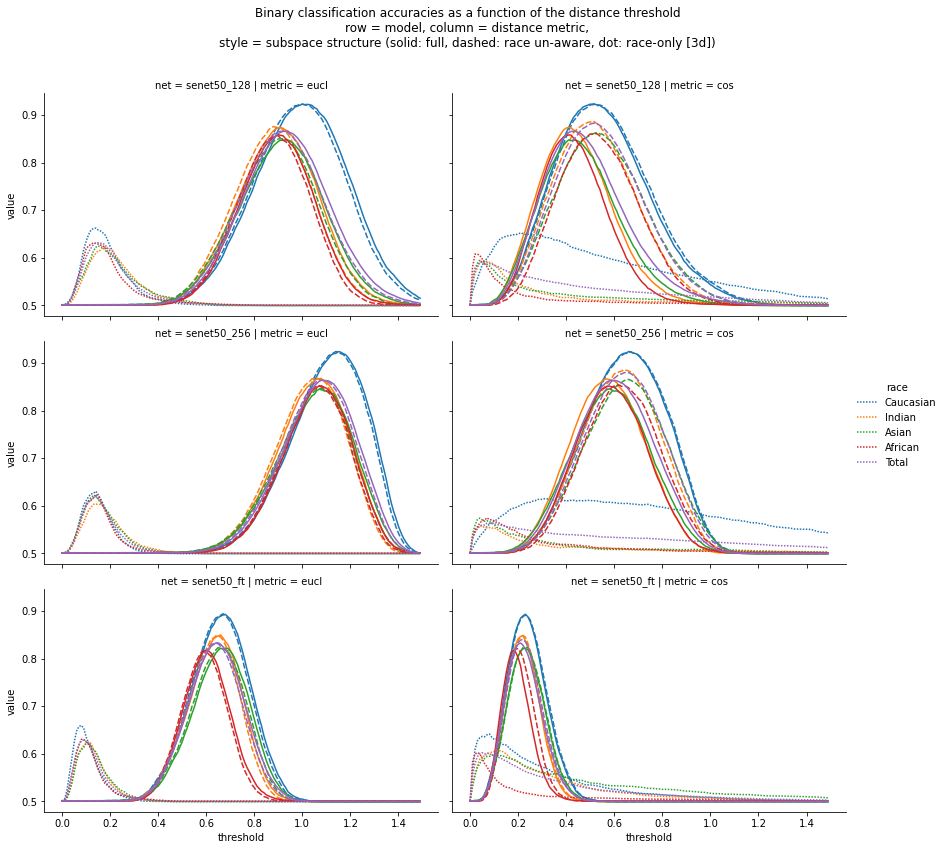

In [78]:
g = sns.FacetGrid(cdf2[cdf2.measure=='acc'],row='net',col='metric',hue='race', hue_order=H5Reader.race_list+['Total'],
                  aspect=1.5,height=4, legend_out=True)
g.map_dataframe(sns.lineplot,'threshold','value',style = 'subspace structure')
g.add_legend()
plt.subplots_adjust(top=0.88)
g.fig.suptitle('\n'.join(['Binary classification accuracies as a function of the distance threshold', 
                          'row = model, column = distance metric,',
                          'style = subspace structure (solid: full, dashed: race un-aware, dot: race-only [3d])']))

plt.savefig('plots/FR_accuracies.png',papertype='A4',dpi=200)
plt.show()

### Values for optimal total accuracy

In [97]:
cdf3 = cdf2.set_index(['measure','metric','race','net','subspace structure','threshold']).unstack([0]).reset_index()
cdf3.columns = [el[1] if (len(el[1])>0) else el[0] for el in cdf3.columns]
cdf3.head()

,metric,race,net,subspace structure,threshold,acc,fnr,fpr
0,cos,African,senet50_128,3d,0.00,0.499916,1.000000,0.000000
1,cos,African,senet50_128,3d,0.01,0.579696,0.653177,0.187354
2,cos,African,senet50_128,3d,0.02,0.607459,0.445151,0.339913
3,cos,African,senet50_128,3d,0.03,0.607459,0.324749,0.460355
4,cos,African,senet50_128,3d,0.04,0.604783,0.242809,0.547675


In [133]:
def optimal_threshold(df):
    ind = np.argmax(df.acc.values)
    return df[['acc','fnr','fpr']].reset_index(drop=True).iloc[ind,:]
    
sel = cdf3['subspace structure'].isin(['aware','blind'])    
(cdf3[sel].groupby(['metric','race','net','subspace structure'])
 .apply(optimal_threshold)
 .stack().unstack([2,3]).round(3).reset_index()
)

net                metric       race level_2 senet50_128        senet50_256  \
subspace structure                                 aware  blind       aware   
0                     cos    African     acc       0.858  0.861       0.851   
1                     cos    African     fnr       0.150  0.139       0.195   
2                     cos    African     fpr       0.133  0.139       0.102   
3                     cos      Asian     acc       0.848  0.863       0.846   
4                     cos      Asian     fnr       0.209  0.144       0.193   
5                     cos      Asian     fpr       0.096  0.130       0.116   
6                     cos  Caucasian     acc       0.923  0.924       0.925   
7                     cos  Caucasian     fnr       0.097  0.082       0.093   
8                     cos  Caucasian     fpr       0.057  0.070       0.058   
9                     cos     Indian     acc       0.874  0.888       0.866   
10                    cos     Indian     fnr       0.168  0.122       0.173   
11                    cos     Indian     fpr       0.083  0.102       0.094   
12                    cos      Total     acc       0.866  0.883       0.863   
13                    cos      Total     fnr       0.143  0.123       0.156   
14                    cos      Total     fpr       0.126  0.111       0.117   
15                   eucl    African     acc       0.859  0.857       0.852   
16                   eucl    African     fnr       0.160  0.160       0.190   
17                   eucl    African     fpr       0.122  0.126       0.105   
18                   eucl      Asian     acc       0.848  0.850       0.847   
19                   eucl      Asian     fnr       0.174  0.171       0.187   
20                   eucl      Asian     fpr       0.131  0.129       0.119   
21                   eucl  Caucasian     acc       0.923  0.923       0.924   
22                   eucl  Caucasian     fnr       0.097  0.092       0.092   
23                   eucl  Caucasian     fpr       0.057  0.061       0.059   
24                   eucl     Indian     acc       0.874  0.876       0.866   
25                   eucl     Indian     fnr       0.161  0.172       0.184   
26                   eucl     Indian     fpr       0.091  0.077       0.083   
27                   eucl      Total     acc       0.866  0.866       0.864   
28                   eucl      Total     fnr       0.169  0.159       0.179   
29                   eucl      Total     fpr       0.099  0.109       0.093   

net                       senet50_ft         
subspace structure  blind      aware  blind  
0                   0.854      0.817  0.821  
1                   0.182      0.234  0.214  
2                   0.110      0.131  0.144  
3                   0.866      0.822  0.824  
4                   0.151      0.195  0.205  
5                   0.118      0.162  0.148  
6                   0.924      0.893  0.892  
7                   0.087      0.109  0.118  
8                   0.065      0.104  0.098  
9                   0.886      0.849  0.848  
10                  0.140      0.164  0.181  
11                  0.088      0.139  0.122  
12                  0.881      0.833  0.840  
13                  0.135      0.193  0.180  
14                  0.104      0.141  0.139  
15                  0.852      0.817  0.816  
16                  0.195      0.234  0.243  
17                  0.101      0.131  0.125  
18                  0.846      0.822  0.823  
19                  0.187      0.245  0.246  
20                  0.121      0.111  0.107  
21                  0.925      0.893  0.894  
22                  0.094      0.107  0.110  
23                  0.057      0.108  0.101  
24                  0.868      0.850  0.848  
25                  0.165      0.172  0.197  
26                  0.099      0.129  0.107  
27                  0.864      0.833  0.833  
28                  0.164      0.188  0.191  
29                  0.108      0.146  0.144

## 6.2 Logistic regression and cosine distance

Insights:
- logistic regression works well as a last step
- weigths don't improve the over results
- also, errors within races cannot systematically be improved

In [66]:
r128 = H5Reader('senet50_128')
labels = r128.read_pair_labels()
embeddings,race_labels = H5Reader.df2data(r128.read_all())
frm = RFWDistances()
ccp = ClusterCenterProjection()
ccp.fit(embeddings,race_labels)

#df = frm.get_distance_df(embeddings,labels).dropna()
df = frm.get_prod_df(ccp.blind(embeddings),labels).dropna()
df.head()

    
 

,race,label1,label2,issame,0,1,2,3,4,5,...,118,119,120,121,122,123,124,125,126,127
0,Caucasian,Caucasian_027n6t8_0003,Caucasian_027n6t8_0002,1,-0.000776,0.001940,-0.004317,0.000541,0.004794,0.000076,...,0.003679,0.000776,-0.012612,0.004575,0.028500,0.007834,0.007345,0.008791,-0.000949,-0.006607
1,Caucasian,Caucasian_016lb3_0004,Caucasian_016lb3_0002,1,0.001977,0.001115,0.085996,-0.000304,0.000037,0.009535,...,-0.000128,-0.000796,0.009894,-0.000611,0.000170,0.001582,0.012668,0.003757,0.000162,-0.008012
2,Caucasian,Caucasian_02_4qt_0003,Caucasian_02_4qt_0002,1,0.015743,0.002594,0.005140,0.001876,-0.000011,0.000334,...,-0.000703,0.005246,0.001164,0.021235,0.003167,-0.001430,0.018861,-0.001998,0.001291,-0.000476
3,Caucasian,Caucasian_09g8fj_0003,Caucasian_09g8fj_0001,1,0.000713,0.000796,-0.005174,0.020006,0.017140,0.009761,...,0.005444,0.017231,0.001361,0.006163,0.001430,0.001128,0.018829,0.025726,-0.000451,0.012281
4,Caucasian,Caucasian_01q3xr_0001,Caucasian_01q3xr_0003,1,0.004055,0.008432,0.005721,0.028036,0.019303,-0.000528,...,0.007079,0.014852,0.000322,0.005450,0.013003,0.006940,-0.000094,0.013286,-0.000062,0.013702


In [138]:
from sklearn.linear_model import LogisticRegression
X = df.filter(regex=r'^\d').values
y = df.issame.values
#sel = df.race == 'Caucasian'
sel = df.race.isin(H5Reader.race_list)
clf = LogisticRegression(random_state=0, C=10, solver = 'liblinear', penalty='l1').fit(X[sel,:], y[sel])
#clf.predict(X)

#clf.predict_proba(X[:2, :])

for irace, race in enumerate(H5Reader.race_list):
    sel = df.race == race
    print(race,clf.score(X[sel,:], y[sel]))

Caucasian 0.9264356099218485
Indian 0.8866451722382488
Asian 0.8666440447913132
African 0.8651948486368958


In [139]:
bad = clf.predict(X) != y
bad_labels = df.label1[bad].values
esel = pd.DataFrame(labels)[0].isin(bad_labels)

In [140]:
1- np.mean(bad)

0.8861407069169627

In [107]:
res = ccp.project(embeddings[esel,:])

[]

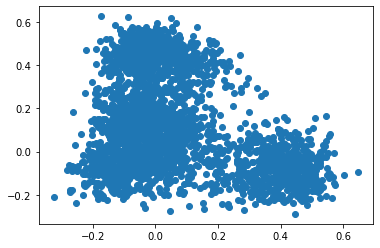

In [112]:
plt.scatter(res[:,0],res[:,1])
plt.plot()

In [81]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(X)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

[0.0442853  0.02199714 0.01895446 0.01741388 0.01673296]
[3.255702  2.294552  2.1299558 2.041562  2.0012498]


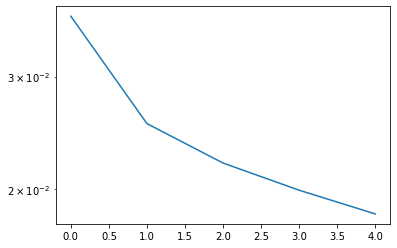

In [80]:
plt.semilogy(pca.explained_variance_ratio_)
plt.show()

In [85]:
np.sum(X,axis=1)

array([0.5900264 , 0.6269361 , 0.66610086, ..., 0.11961102, 0.31383666,
       0.38623294], dtype=float32)

In [ ]:
sel = (df.timestamp >= start) & (df.timestamp <= end)
df.loc[sel,'de_morton_label'] = label
df.loc[sel,'de_morton'] = 1

In [146]:
sel = df.label1 == 'Caucasian_027n6t8_0003'
df.loc[sel,'issame'] = 1
df

,race,label1,label2,issame,0,1,2,3,4,5,...,118,119,120,121,122,123,124,125,126,127
0,Caucasian,Caucasian_027n6t8_0003,Caucasian_027n6t8_0002,1,-0.000776,0.001940,-0.004317,0.000541,0.004794,0.000076,...,0.003679,0.000776,-0.012612,0.004575,0.028500,0.007834,0.007345,0.008791,-0.000949,-0.006607
1,Caucasian,Caucasian_016lb3_0004,Caucasian_016lb3_0002,1,0.001977,0.001115,0.085996,-0.000304,0.000037,0.009535,...,-0.000128,-0.000796,0.009894,-0.000611,0.000170,0.001582,0.012668,0.003757,0.000162,-0.008012
2,Caucasian,Caucasian_02_4qt_0003,Caucasian_02_4qt_0002,1,0.015743,0.002594,0.005140,0.001876,-0.000011,0.000334,...,-0.000703,0.005246,0.001164,0.021235,0.003167,-0.001430,0.018861,-0.001998,0.001291,-0.000476
3,Caucasian,Caucasian_09g8fj_0003,Caucasian_09g8fj_0001,1,0.000713,0.000796,-0.005174,0.020006,0.017140,0.009761,...,0.005444,0.017231,0.001361,0.006163,0.001430,0.001128,0.018829,0.025726,-0.000451,0.012281
4,Caucasian,Caucasian_01q3xr_0001,Caucasian_01q3xr_0003,1,0.004055,0.008432,0.005721,0.028036,0.019303,-0.000528,...,0.007079,0.014852,0.000322,0.005450,0.013003,0.006940,-0.000094,0.013286,-0.000062,0.013702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,African,African_04zxpvp_0003,African_02r1g27_0003,0,0.000050,0.002746,0.001282,-0.000905,0.001890,0.003564,...,0.001614,0.000306,-0.000171,0.000592,0.013240,0.020314,0.016989,0.004621,0.005426,-0.004709
23996,African,African_03gymy_0005,African_02x35pc_0002,0,-0.002090,0.002910,0.004676,-0.003356,-0.006661,0.000236,...,0.000055,-0.002841,-0.000043,-0.007228,0.016323,-0.013427,-0.001012,0.005683,-0.016941,-0.001087
23997,African,African_05p823_0004,African_0ndhf39_0002,0,0.008482,0.000254,-0.007339,-0.000980,0.000246,-0.009237,...,-0.001955,0.001741,-0.008819,0.000313,0.026764,-0.002281,-0.001476,-0.011617,0.003031,-0.008027
23998,African,African_02rmtpx_0002,African_08fz0m_0003,0,0.006992,-0.002535,-0.000295,-0.001641,0.000928,-0.000390,...,0.017109,-0.001679,0.008675,-0.006267,-0.001699,0.001487,0.018807,0.006774,-0.003193,-0.000454


# xxx. Other stuff

PCA calculates normalized variance $p_i$ such that $\sum p_i = 1$. Here I define a variance spread as

$$ h = \sum_i i * p_i $$

- Bigger h means that variance spreads over more components, i.e. more dimensions. 
- Below: h is calculated with a seperate pca for each class.
- Fit is done with a fit-paremeter per model

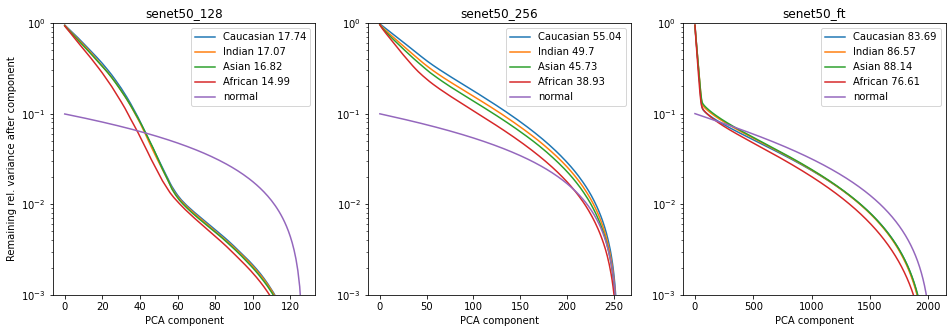

In [93]:
pca = PCA(svd_solver='full')
N=9500

hmat = np.zeros([3,4])
fig, axs = plt.subplots(1, 3, figsize=(16,5))
for inet,net in enumerate(H5Reader.net_list):
    rd = H5Reader(net)
    for irace,race in enumerate(H5Reader.race_list):
        X = rd.read(race).head(N).values
        #X = X - np.mean(X,0,keepdims=True)
        pca.fit(X)
        var = pca.explained_variance_ratio_
        #var = var/np.sum(var)
        h = np.dot(var,np.arange(len(var)))
        hmat[inet,irace]=h
        axs[inet].semilogy(1 - np.cumsum(var),label=race+' '+str(np.round(h,2)))
    
    pca.fit(np.random.normal(size=[N,X.shape[1]]))
    var = pca.explained_variance_ratio_
    axs[inet].semilogy((1 - np.cumsum(var))/10,label='normal')

    axs[inet].legend()
    axs[inet].set_title('senet50_'+net)
    axs[inet].set_ylim([0.001,1])
    #axs[inet].set_xlim([0,150])
    axs[inet].set_xlabel('PCA component')
    
    if inet == 0:
        axs[inet].set_ylabel('Remaining rel. variance after component')
    
plt.show()

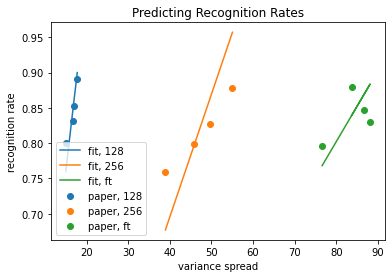

In [86]:
# recognition rate
recrate=[[0.8906,0.8531,0.8310,0.7998],
        [0.8787,0.8265,0.7981,0.7597],
        [0.8799,0.8472,0.8305,0.7959]]

recrate_fit = hmat*np.mean(recrate/hmat,1,keepdims=1)

for inet, net in enumerate(H5Reader.net_list):
    plt.scatter(hmat[inet],recrate[inet],label='paper, ' + net)
    plt.plot(hmat[inet],recrate_fit[inet],label='fit, '+net)
plt.legend()
plt.xlabel('variance spread')
plt.ylabel('recognition rate')
plt.title('Predicting Recognition Rates')
plt.show()